In [1]:
"""
Simple policy gradient in Keras
"""
import gym
import numpy as np

from keras import layers
from keras.models import Model
from keras import backend as K
from keras import utils as np_utils
from keras import optimizers
from reinforce_keras import Agent

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
class Agent2:

    def __init__(self, input_dim, output_dim, hidden_dims=[32, 32]):
        """Gym Playing Agent
        Args:
            input_dim (int): the dimension of state.
                Same as `env.observation_space.shape[0]`
            output_dim (int): the number of discrete actions
                Same as `env.action_space.n`
            hidden_dims (list): hidden dimensions
        Methods:
            private:
                __build_train_fn -> None
                    It creates a train function
                    It's similar to defining `train_op` in Tensorflow
                __build_network -> None
                    It create a base model
                    Its output is each action probability
            public:
                get_action(state) -> action
                fit(state, action, reward) -> None
        """

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.__build_network(input_dim, output_dim, hidden_dims)
        self.__build_train_fn()

    def __build_network(self, input_dim, output_dim, hidden_dims=[32, 32]):
        """Create a base network"""
        self.X = layers.Input(shape=(input_dim,))
        net = self.X

        for h_dim in hidden_dims:
            net = layers.Dense(h_dim)(net)
            net = layers.Activation("relu")(net)

        net = layers.Dense(output_dim)(net)
        net = layers.Activation("softmax")(net)

        self.model = Model(inputs=self.X, outputs=net)

    def __build_train_fn(self):
        """Create a train function
        It replaces `model.fit(X, y)` because we use the output of model and use it for training.
        For example, we need action placeholder
        called `action_one_hot` that stores, which action we took at state `s`.
        Hence, we can update the same action.
        This function will create
        `self.train_fn([state, action_one_hot, discount_reward])`
        which would train the model.
        """
        action_prob_placeholder = self.model.output
        action_onehot_placeholder = K.placeholder(shape=(None, self.output_dim),
                                                  name="action_onehot")
        discount_reward_placeholder = K.placeholder(shape=(None,),
                                                    name="discount_reward")

        action_prob = K.sum(action_prob_placeholder * action_onehot_placeholder, axis=1)
        log_action_prob = K.log(action_prob)

        loss = - log_action_prob * discount_reward_placeholder
        loss = K.mean(loss)

        adam = optimizers.Adam()

        updates = adam.get_updates(params=self.model.trainable_weights,
                                   loss=loss)

        self.train_fn = K.function(inputs=[self.model.input,
                                           action_onehot_placeholder,
                                           discount_reward_placeholder],
                                   outputs=[],
                                   updates=updates)

    def get_action(self, state):
        """Returns an action at given `state`
        Args:
            state (1-D or 2-D Array): It can be either 1-D array of shape (state_dimension, )
                or 2-D array shape of (n_samples, state_dimension)
        Returns:
            action: an integer action value ranging from 0 to (n_actions - 1)
        """
        shape = state.shape

        if len(shape) == 1:
            assert shape == (self.input_dim,), "{} != {}".format(shape, self.input_dim)
            state = np.expand_dims(state, axis=0)

        elif len(shape) == 2:
            assert shape[1] == (self.input_dim), "{} != {}".format(shape, self.input_dim)

        else:
            raise TypeError("Wrong state shape is given: {}".format(state.shape))

        action_prob = np.squeeze(self.model.predict(state))
        assert len(action_prob) == self.output_dim, "{} != {}".format(len(action_prob), self.output_dim)
        return np.random.choice(np.arange(self.output_dim), p=action_prob)

    def fit(self, S, A, R):
        """Train a network
        Args:
            S (2-D Array): `state` array of shape (n_samples, state_dimension)
            A (1-D Array): `action` array of shape (n_samples,)
                It's simply a list of int that stores which actions the agent chose
            R (1-D Array): `reward` array of shape (n_samples,)
                A reward is given after each action.
        """
        action_onehot = np_utils.to_categorical(A, num_classes=self.output_dim)
        discount_reward = compute_discounted_R(R)

        assert S.shape[1] == self.input_dim, "{} != {}".format(S.shape[1], self.input_dim)
        assert action_onehot.shape[0] == S.shape[0], "{} != {}".format(action_onehot.shape[0], S.shape[0])
        assert action_onehot.shape[1] == self.output_dim, "{} != {}".format(action_onehot.shape[1], self.output_dim)
        assert len(discount_reward.shape) == 1, "{} != 1".format(len(discount_reward.shape))

        self.train_fn([S, action_onehot, discount_reward])


def compute_discounted_R(R, discount_rate=.99):
    """Returns discounted rewards
    Args:
        R (1-D array): a list of `reward` at each time step
        discount_rate (float): Will discount the future value by this rate
    Returns:
        discounted_r (1-D array): same shape as input `R`
            but the values are discounted
    Examples:
        >>> R = [1, 1, 1]
        >>> compute_discounted_R(R, .99) # before normalization
        [1 + 0.99 + 0.99**2, 1 + 0.99, 1]
    """
    discounted_r = np.zeros_like(R, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(R))):

        running_add = running_add * discount_rate + R[t]
        discounted_r[t] = running_add

    discounted_r -= discounted_r.mean() / discounted_r.std()

    return discounted_r


def run_episode(env, agent):
    """Returns an episode reward
    (1) Play until the game is done
    (2) The agent will choose an action according to the policy
    (3) When it's done, it will train from the game play
    Args:
        env (gym.env): Gym environment
        agent (Agent): Game Playing Agent
    Returns:
        total_reward (int): total reward earned during the whole episode
    """
    done = False
    S = []
    A = []
    R = []

    s = env.reset()

    total_reward = 0

    while not done:

        a = agent.get_action(s)

        s2, r, done, info = env.step(a)
        total_reward += r

        S.append(s)
        A.append(a)
        R.append(r)

        s = s2

        if done:
            S = np.array(S)
            A = np.array(A)
            R = np.array(R)

            agent.fit(S, A, R)

    return total_reward

In [5]:
env = gym.make("CartPole-v0")
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
agent = Agent2(input_dim, output_dim, [16, 16])
rewards = []
for episode in range(4000):
    reward = run_episode(env, agent)
    rewards.append(reward)
    if episode % 50 == 0:
        print(episode, reward)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


c:\users\richardsr\appdata\local\programs\python\python37\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [6]:
df_rewards = pd.DataFrame(rewards)

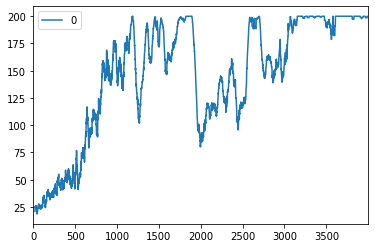

In [7]:
df_rewards.rolling(20).mean().plot()

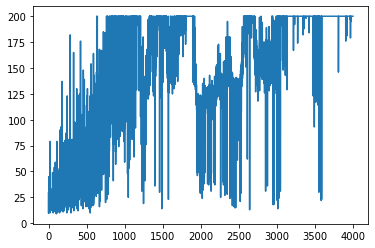

In [8]:
plt.plot(rewards)

In [16]:
env.step(0)

(array([-0.12101189, -1.80263794,  0.18855115,  2.7182945 ]), 1.0, False, {})

In [26]:
obs = env.step(1)

In [32]:
obs = env.reset()

In [83]:
agent = Agent(ALPHA = .0005, input_dims = 3, n_actions = 2)

In [84]:
plc, prdct = agent.build_policy_network()

In [85]:
prdct.predict([[[0,-0.2,0.1],[0,-0.2,0.2],[0,-0.2,0.3]]])

array([[0.4855596 , 0.5144405 ],
       [0.4879257 , 0.5120743 ],
       [0.49313313, 0.50686693]], dtype=float32)

In [82]:
obs

array([-0.02884268, -0.0396217 , -0.02438983,  0.02261002])

In [41]:
obs[np.newaxis, :]

array([[-0.02884268, -0.0396217 , -0.02438983,  0.02261002]])

In [3]:
agent = Agent(ALPHA=0.0005, input_dims = 4, GAMMA = 0.99, n_actions = 2,
             layer1_size=64, layer2_size=64)

env = gym.make('CartPole-v0')
score_history = []

n_episodes = 2000

for i in range(n_episodes):
    # per episode
    done = False
    score = 0
    observation = env.reset()
    # wait until episode is done
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.store_transition(observation, action, reward)
        observation = observation_
        score += reward
    score_history.append(score)

    agent.learn()

    print('episode', i, 'score %.1f' % score)

D:\git\ClashRoyaleMachine\pg_tests\reinforce_keras.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  policy = Model(input=[input, advantages], output = [probs])
D:\git\ClashRoyaleMachine\pg_tests\reinforce_keras.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  predict = Model(input = [input], output = [probs])
c:\users\richardsr\appdata\local\programs\python\python37\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode 0 score 27.0
episode 1 score 40.0
episode 2 score 27.0
episode 3 score 11.0
episode 4 score 40.0
episode 5 score 33.0
episode 6 score 16.0
episode 7 score 14.0
episode 8 score 53.0
episode 9 score 47.0
episode 10 score 17.0
episode 11 score 15.0
episode 12 score 51.0
episode 13 score 14.0
episode 14 score 37.0
episode 15 score 14.0
episode 16 score 21.0
episode 17 score 24.0
episode 18 score 73.0
episode 19 score 15.0
episode 20 score 37.0
episode 21 score 24.0
episode 22 score 40.0
episode 23 score 24.0
episode 24 score 42.0
episode 25 score 14.0
episode 26 score 55.0
episode 27 score 14.0
episode 28 score 11.0
episode 29 score 17.0
episode 30 score 20.0
episode 31 score 15.0
episode 32 score 43.0
episode 33 score 29.0
episode 34 score 23.0
episode 35 score 25.0
episode 36 score 28.0
episode 37 score 24.0
episode 38 score 36.0
episode 39 score 23.0
episode 40 score 21.0
episode 4

episode 351 score 109.0
episode 352 score 200.0
episode 353 score 126.0
episode 354 score 193.0
episode 355 score 60.0
episode 356 score 83.0
episode 357 score 179.0
episode 358 score 200.0
episode 359 score 200.0
episode 360 score 156.0
episode 361 score 200.0
episode 362 score 200.0
episode 363 score 200.0
episode 364 score 200.0
episode 365 score 200.0
episode 366 score 200.0
episode 367 score 149.0
episode 368 score 164.0
episode 369 score 200.0
episode 370 score 200.0
episode 371 score 200.0
episode 372 score 200.0
episode 373 score 200.0
episode 374 score 200.0
episode 375 score 200.0
episode 376 score 200.0
episode 377 score 200.0
episode 378 score 200.0
episode 379 score 138.0
episode 380 score 200.0
episode 381 score 200.0
episode 382 score 200.0
episode 383 score 200.0
episode 384 score 97.0
episode 385 score 200.0
episode 386 score 200.0
episode 387 score 200.0
episode 388 score 198.0
episode 389 score 200.0
episode 390 score 200.0
episode 391 score 200.0
episode 392 score 2

episode 695 score 125.0
episode 696 score 200.0
episode 697 score 150.0
episode 698 score 200.0
episode 699 score 200.0
episode 700 score 186.0
episode 701 score 200.0
episode 702 score 200.0
episode 703 score 133.0
episode 704 score 156.0
episode 705 score 183.0
episode 706 score 200.0
episode 707 score 200.0
episode 708 score 200.0
episode 709 score 187.0
episode 710 score 183.0
episode 711 score 198.0
episode 712 score 169.0
episode 713 score 155.0
episode 714 score 155.0
episode 715 score 148.0
episode 716 score 175.0
episode 717 score 126.0
episode 718 score 172.0
episode 719 score 182.0
episode 720 score 197.0
episode 721 score 200.0
episode 722 score 171.0
episode 723 score 92.0
episode 724 score 144.0
episode 725 score 132.0
episode 726 score 140.0
episode 727 score 124.0
episode 728 score 163.0
episode 729 score 131.0
episode 730 score 172.0
episode 731 score 192.0
episode 732 score 127.0
episode 733 score 200.0
episode 734 score 200.0
episode 735 score 200.0
episode 736 score

episode 1036 score 200.0
episode 1037 score 200.0
episode 1038 score 200.0
episode 1039 score 200.0
episode 1040 score 200.0
episode 1041 score 200.0
episode 1042 score 200.0
episode 1043 score 200.0
episode 1044 score 200.0
episode 1045 score 200.0
episode 1046 score 200.0
episode 1047 score 200.0
episode 1048 score 200.0
episode 1049 score 200.0
episode 1050 score 200.0
episode 1051 score 200.0
episode 1052 score 200.0
episode 1053 score 200.0
episode 1054 score 200.0
episode 1055 score 200.0
episode 1056 score 200.0
episode 1057 score 200.0
episode 1058 score 200.0
episode 1059 score 200.0
episode 1060 score 200.0
episode 1061 score 200.0
episode 1062 score 200.0
episode 1063 score 200.0
episode 1064 score 200.0
episode 1065 score 200.0
episode 1066 score 200.0
episode 1067 score 200.0
episode 1068 score 200.0
episode 1069 score 200.0
episode 1070 score 200.0
episode 1071 score 200.0
episode 1072 score 200.0
episode 1073 score 200.0
episode 1074 score 200.0
episode 1075 score 200.0


episode 1365 score 200.0
episode 1366 score 200.0
episode 1367 score 200.0
episode 1368 score 200.0
episode 1369 score 200.0
episode 1370 score 200.0
episode 1371 score 200.0
episode 1372 score 200.0
episode 1373 score 200.0
episode 1374 score 200.0
episode 1375 score 200.0
episode 1376 score 200.0
episode 1377 score 200.0
episode 1378 score 200.0
episode 1379 score 200.0
episode 1380 score 200.0
episode 1381 score 198.0
episode 1382 score 200.0
episode 1383 score 200.0
episode 1384 score 200.0
episode 1385 score 200.0
episode 1386 score 200.0
episode 1387 score 200.0
episode 1388 score 200.0
episode 1389 score 200.0
episode 1390 score 200.0
episode 1391 score 193.0
episode 1392 score 200.0
episode 1393 score 200.0
episode 1394 score 197.0
episode 1395 score 200.0
episode 1396 score 200.0
episode 1397 score 200.0
episode 1398 score 200.0
episode 1399 score 200.0
episode 1400 score 200.0
episode 1401 score 200.0
episode 1402 score 200.0
episode 1403 score 200.0
episode 1404 score 200.0


episode 1694 score 200.0
episode 1695 score 200.0
episode 1696 score 200.0
episode 1697 score 200.0
episode 1698 score 200.0
episode 1699 score 200.0
episode 1700 score 200.0
episode 1701 score 200.0
episode 1702 score 200.0
episode 1703 score 200.0
episode 1704 score 200.0
episode 1705 score 200.0
episode 1706 score 200.0
episode 1707 score 200.0
episode 1708 score 200.0
episode 1709 score 200.0
episode 1710 score 200.0
episode 1711 score 200.0
episode 1712 score 200.0
episode 1713 score 200.0
episode 1714 score 200.0
episode 1715 score 200.0
episode 1716 score 200.0
episode 1717 score 200.0
episode 1718 score 200.0
episode 1719 score 200.0
episode 1720 score 200.0
episode 1721 score 200.0
episode 1722 score 200.0
episode 1723 score 200.0
episode 1724 score 200.0
episode 1725 score 200.0
episode 1726 score 200.0
episode 1727 score 200.0
episode 1728 score 200.0
episode 1729 score 200.0
episode 1730 score 200.0
episode 1731 score 200.0
episode 1732 score 200.0
episode 1733 score 200.0


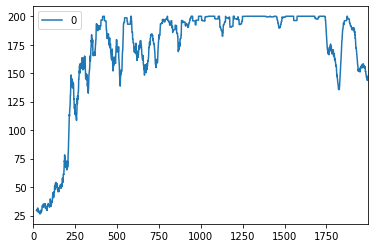

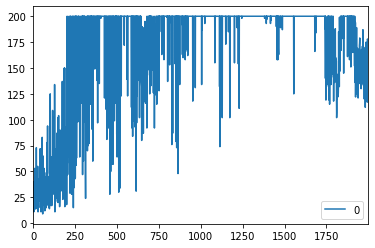

In [4]:
df_score = pd.DataFrame(score_history)
df_score.rolling(20).mean().plot()
df_score.plot()